In [1]:
import torch
from torch import nn
from functools import partial

In [2]:
# --------------------------------------- #
#（1）patch embedding
'''
img_size=224 : 输入图像的宽高
patch_size=16 ： 每个patch的宽高，也是卷积核的尺寸和步长
in_c=3 ： 输入图像的通道数
embed_dim=768 ： 卷积输出通道数
'''
# --------------------------------------- #
class patchembed(nn.Module):
    # 初始化
    def __init__(self, img_size=480, patch_size=16, in_c=3, embed_dim=768):
        super(patchembed, self).__init__()
        
        # 输入图像的尺寸224*224
        self.img_size = (img_size, img_size)
        # 每个patch的大小16*16
        self.patch_size = (patch_size, patch_size)
        # 将输入图像划分成14*14个patch
        self.grid_size = (img_size//patch_size, img_size//patch_size)
        # 一共有14*14个patch
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        
        # 使用16*16的卷积切分图像，将图像分成14*14个
        self.proj = nn.Conv2d(in_channels=in_c, out_channels=embed_dim, 
                              kernel_size=patch_size, stride=patch_size)
        
        # 定义标准化方法，给LN传入默认参数eps
        norm_layer = partial(nn.LayerNorm, eps=1e-6)
        self.norm = norm_layer(embed_dim)
        
        
    # 前向传播
    def forward(self, inputs):
        # 获得输入图像的shape
        B, C, H, W = inputs.shape
        
        # 如果输入图像的宽高不等于224*224就报错
        assert H==self.img_size[0] and W==self.img_size[1], 'input shape does not match 224*224'
        
        # 卷积层切分patch [b,3,224,224]==>[b,768,14,14]
        x = self.proj(inputs)
        # 展平 [b,768,14,14]==>[b,768,14*14]
        x = x.flatten(start_dim=2, end_dim=-1)  # 将索引为 start_dim 和 end_dim 之间（包括该位置）的数量相乘
        # 维度调整 [b,768,14*14]==>[b,14*14,768]
        x = x.transpose(1, 2)  # 实现一个张量的两个轴之间的维度转换
        # 标准化
        x = self.norm(x)
        
        return x

In [3]:
# --------------------------------------- #
#（2）类别标签和位置标签
'''
embed_dim : 代表patchembed层输出的通道数
'''
# --------------------------------------- #
class class_token_pos_embed(nn.Module):
    # 初始化
    def __init__(self, embed_dim):
        super(class_token_pos_embed, self).__init__()
        
        # patchembed层将图像划分的patch个数==14*14
        num_patches = patchembed().num_patches
        
        self.num_tokens = 1  # 类别标签
        
        # 创建可学习的类别标签 [1,1,768]
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # 创建可学习的位置编码 [1,196+1,768]
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+self.num_tokens, embed_dim))
        
        # 权重以正态分布初始化
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
 
    # 前向传播
    def forward(self, x):  # 输入特征图的shape=[b,196,768]
        
        # 类别标签扩充维度 [1,1,768]==>[b,1,768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
 
        # 将类别标签添加到特征图中 [b,1,768]+[b,196,768]==>[b,197,768]
        x = torch.cat((cls_token, x), dim=1)
        
        # 添加位置编码 [b,197,768]+[1,197,768]==>[b,197,768]
        x = x + self.pos_embed
        
        return x

In [4]:
# --------------------------------------- #
#（3）多头注意力模块
'''
dim : 代表输入特征图的通道数
num_heads : 多头注意力中heads的个数
qkv_bias ： 生成qkv时是否使用偏置 
atten_drop_ratio ：qk计算完之后的dropout层
proj_drop_ratio ： qkv计算完成之后的dropout层
'''
# --------------------------------------- #
class attention(nn.Module):
    # 初始化
    def __init__(self, dim, num_heads=6, qkv_bias=False, atten_drop_ratio=0., proj_drop_ratio=0.):
        super(attention, self).__init__()
        
        # 多头注意力的数量
        self.num_heads = num_heads  
        # 将生成的qkv均分成num_heads个。得到每个head的qkv对应的通道数。
        head_dim = dim // num_heads
        # 公式中的分母
        self.scale = head_dim ** -0.5
        
        # 通过一个全连接层计算qkv
        self.qkv = nn.Linear(in_features=dim, out_features=dim*3, bias=qkv_bias)
        # dropout层
        self.atten_drop = nn.Dropout(atten_drop_ratio)
        
        # 再qkv计算完之后通过一个全连接提取特征
        self.proj = nn.Linear(in_features=dim, out_features=dim)
        # dropout层
        self.proj_drop = nn.Dropout(proj_drop_ratio)
    
    # 前向传播
    def forward(self, inputs):
        # 获取输入图像的shape=[b,197,768]
        B, N, C = inputs.shape
        
        # 将输入特征图经过全连接层生成qkv [b,197,768]==>[b,197,768*3]
        qkv = self.qkv(inputs)
 
        # 维度调整 [b,197,768*3]==>[b, 197, 3, 12, 768//12]
        qkv = qkv.reshape(B, N, 3, self.num_heads, C//self.num_heads)
        # 维度重排==> [3, B, 12, 197, 768//12]
        qkv = qkv.permute(2,0,3,1,4)
        # 切片提取q、k、v的值，单个的shape=[B, 12, 197, 768//12]
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # 针对每个head计算 ==> [B, 12, 197, 197] 
        atten = (q @ k.transpose(-2,-1)) * self.scale  # @ 代表在多维tensor的最后两个维度矩阵相乘
        # 对计算结果的每一行经过softmax
        atten = atten.softmax(dim=-1)
        # dropout层
        atten = self.atten_drop(atten)
        
        # softmax后的结果和v加权 ==> [B, 12, 197, 768//12]
        x = atten @ v
        # 通道重排 ==> [B, 197, 12, 768//12]
        x = x.transpose(1,2)
        # 维度调整 ==> [B, 197, 768]
        x = x.reshape(B,N,C)
        
        # 通过全连接层融合特征 ==> [B, 197, 768]
        x = self.proj(x)
        # dropout层
        x = self.proj_drop(x)
        
        return x

In [5]:
# --------------------------------------- #
#（4）MLP多层感知器
'''
in_features : 输入特征图的通道数
hidden_features : 第一个全连接层上升通道数
out_features : 第二个全连接层的下降的通道数
drop : 全连接层后面的dropout层的杀死神经元的概率
'''
# --------------------------------------- #  
class MLP(nn.Module):
    # 初始化
    def __init__(self, in_features, hidden_features, out_features=None, drop=0.):
        super(MLP, self).__init__()
        
        # MLP的输出通道数默认等于输入通道数
        out_features = out_features or in_features
        # 第一个全连接层上升通道数
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        # GeLU激活函数
        self.act = nn.GELU()
        # 第二个全连接下降通道数
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=out_features)
        # dropout层
        self.drop = nn.Dropout(drop)
    
    # 前向传播
    def forward(self, inputs):
        
        # [b,197,768]==>[b,197,3072]
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.drop(x)
        
        # [b,197,3072]==>[b,197,768]
        x = self.fc2(x)
        x = self.drop(x)
        
        return x

In [6]:
# --------------------------------------- #
#（5）Encoder Block
'''
dim : 该模块的输入特征图个数
mlp_ratio ： MLP中第一个全连接层上升的通道数
drop_ratio : 该模块的dropout层的杀死神经元的概率
'''
# --------------------------------------- # 
class encoder_block(nn.Module):
    # 初始化
    def __init__(self, dim, mlp_ratio=4., drop_ratio=0.):
        super(encoder_block, self).__init__()
        
        # LayerNormalization层
        self.norm1 = nn.LayerNorm(dim)
        # 实例化多头注意力
        self.atten = attention(dim)
        # dropout
        self.drop = nn.Dropout()
        
        # LayerNormalization层
        self.norm2 = nn.LayerNorm(dim)
        # MLP中第一个全连接层上升的通道数
        hidden_features = int(dim * mlp_ratio)
        # MLP多层感知器
        self.mlp = MLP(in_features=dim, hidden_features=hidden_features)
        
    # 前向传播
    def forward(self, inputs):
        
        # [b,197,768]==>[b,197,768]
        x = self.norm1(inputs)
        x = self.atten(x)
        x = self.drop(x)
        feat1 = x + inputs  # 残差连接
        
        # [b,197,768]==>[b,197,768]
        x = self.norm2(feat1)
        x = self.mlp(x)
        x = self.drop(x)
        feat2 = x + feat1  # 残差连接
        
        return feat2

In [7]:
# --------------------------------------- #
#（6）主干网络
'''
num_class: 分类数
depth : 重复堆叠encoder_block的次数
drop_ratio : 位置编码后的dropout层
embed_dim : patchembed层输出通道数
'''
# --------------------------------------- # 
class VIT(nn.Module):
    # 初始化
    def __init__(self, num_classes=1000, depth=6, drop_ratio=0., embed_dim=768):
        super(VIT, self).__init__()
        
        self.num_classes = num_classes  # 分类类别数
        
        # 实例化patchembed层
        self.patchembed = patchembed()
        
        # 实例化类别标签和位置编码
        self.cls_pos_embed = class_token_pos_embed(embed_dim=embed_dim)        
 
        # 位置编码后做dropout
        self.pos_drop = nn.Dropout(drop_ratio)
        
        # 在列表中添加12个encoder_block
        self.blocks = nn.Sequential(*[encoder_block(dim=embed_dim) for _ in range(depth)])
        
        # 定义LayerNormalization标准化方法
        norm_layer = partial(nn.LayerNorm, eps=1e-6)
        # 经过12个encoder之后的标准化层
        self.norm = norm_layer(embed_dim)
        
        # 分类层
        self.head = nn.Linear(in_features=embed_dim, out_features=num_classes)
        
        # 权值初始化
        for m in self.modules():
            # 对卷积层使用kaiming初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                # 对偏置初始化
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            # 对标准化层初始化
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            # 对全连接层初始化
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
 
    
    # 前向传播
    def forward(self, inputs):
        
        # 先将输入传递给patchembed [b,3,224,224]==>[b,196,768]
        x = self.patchembed(inputs)
        
        # 对特征图添加类别标签和位置编码
        x = self.cls_pos_embed(x)
        
        # dropout层
        x = self.pos_drop(x)
        
        # 经过12个encoder层==>[b,197,768]
        x = self.blocks(x)
        
        # LN标准化层
        x = self.norm(x)
        
        # 提取类别标签的输出,因为在cat时将类别标签放在最前面
        x = x[:, 0]  # [b,197,768]==>[b,768]
 
        # 全连接层分类 [b,768]==>[b,1000]
        x = self.head(x)
        
        return x

In [8]:
import  torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 绘图显示中文
 
 
# --------------------------------------------- #
#（0）参数设置
# --------------------------------------------- #
batch_size = 5  # 每个step处理16张图片
epochs = 10  # 训练10轮
best_loss = 1.5  # 当验证集损失小于1时才保存权重
 
# 数据集目录位置
filepath = 'Baidu'
# 验证集目录
varpath = '验证'
# 预训练权重位置
weightpath = 'checkpoint/vit.pth'

 
# 获取GPU设备，检测到了就用GPU，检测不到就用CPU
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [9]:
# --------------------------------------------- #
#（1）数据集处理
# --------------------------------------------- #
# 定义预处理方法
data_transform = {
    # 训练集预处理方法
    'train' : transforms.Compose([
        transforms.Resize((480,480)),  # 将原始图片缩放至224*224大小
        #transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ToTensor(),  # numpy类型变tensor，维度调整，数据归一化
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])   # 对图像的三个通道分别做标准化
        ]),
    
    # 验证集预处理方法
    'val' : transforms.Compose([
        transforms.Resize((480,480)),  # 将输入图像缩放至224*224大小
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
    }
 
 
# 加载数据集
datasets = {
    'train' : datasets.ImageFolder(filepath, transform=data_transform['train']),  # 读取训练集
    'val'   : datasets.ImageFolder(varpath, transform=data_transform['val'])  # 读取验证集
    }
 
 
# 构造数据集
dataloader = {
    'train' : DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),  # 构造训练集
    'val'   : DataLoader(datasets['val'], batch_size=batch_size, shuffle=True)   # 构造验证集
    }
 
 
# --------------------------------------------- #
#（2）查看数据集信息
# --------------------------------------------- #
train_num = len(datasets['train'])  # 查看训练集数量
val_num = len(datasets['val'])  # 查看验证集数量
 
# 查看分类类别及其索引  {0: 'cats', 1: 'dogs', 2: 'panda'}
class_names = dict((v,k) for k,v in datasets['train'].class_to_idx.items())
print(class_names)
class_names = dict((v,k) for k,v in datasets['val'].class_to_idx.items())
print(class_names)
# 从训练集中取出一个batch，接收图片及其标签
train_imgs, train_labels = next(iter(dataloader['train']))
test_imgs, test_labels = next(iter(dataloader['val']))
# 查看图像的标签及其shape  [32, 3, 224, 224]  [32]
print('img:', train_imgs.shape, 'labels:', train_labels.shape)
print('img:', test_imgs.shape, 'labels:', test_labels.shape)

{0: 'bear1', 1: 'bird1', 2: 'cat1', 3: 'dog1', 4: 'snake1'}
{0: 'bear', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'snake'}
img: torch.Size([5, 3, 480, 480]) labels: torch.Size([5])
img: torch.Size([5, 3, 480, 480]) labels: torch.Size([5])


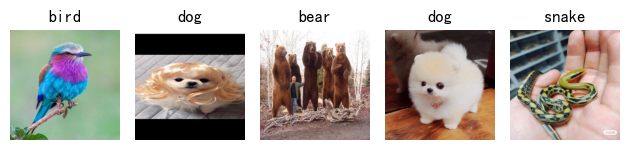

In [10]:
# --------------------------------------------- #
#（3）数据可视化
# --------------------------------------------- #
# 从数据集中取出12张图及其标签
frames = train_imgs[:12]
frames_labels = train_labels[:12]
 
# 将数据类型从tensor变回numpy
frames = frames.numpy()
# 维度调整 [b,c,h,w]==>[b,h,w,c]
frames = np.transpose(frames, [0,2,3,1])
 
# 对图像做反标准化处理
mean = [0.485, 0.456, 0.406]  # 均值
std = [0.229, 0.224, 0.225]   # 标准化
# 图像的每个通道的特征图乘标准化加均值
frames = frames * std + mean
 
# 将像素值限制在0-1之间
frames = np.clip(frames, 0, 1)
 
# 绘制12张图像及其标签
plt.figure()  # 创建画板
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(frames[i])
    plt.axis('off')  # 不显示坐标刻度
    plt.title(class_names[frames_labels[i].item()])  # 显示每张图片的标签
plt.tight_layout()  # 轻量化布局
plt.show()

In [11]:
# --------------------------------------------- #
#（4）模型加载，迁移学习
# --------------------------------------------- #
# 接收VIT模型，三分类
model = VIT(num_classes=5)
 
# 加载预训练权重文件，文件中的分类层神经元个数是1k
pre = 0
if pre:
    model.load_state_dict(torch.load(weightpath, map_location=device))
 

step:0, train_loss:0.8582557439804077
step:20, train_loss:1.6247040033340454
step:40, train_loss:1.462721586227417
step:60, train_loss:1.185525894165039
step:80, train_loss:1.4395217895507812
step:100, train_loss:1.5512334108352661
------------------------------
train_loss:1.4587675333023071, val_loss:1.5187468528747559, val_acc:0.36666667461395264
step:0, train_loss:2.4079699516296387
step:20, train_loss:1.2120964527130127
step:40, train_loss:1.4956668615341187
step:60, train_loss:0.9674471020698547
step:80, train_loss:1.4172532558441162
step:100, train_loss:1.5418452024459839
------------------------------
train_loss:1.4527987241744995, val_loss:1.4803645610809326, val_acc:0.3777777850627899
step:0, train_loss:0.925574779510498
step:20, train_loss:1.048385739326477
step:40, train_loss:1.3143112659454346
step:60, train_loss:1.602161169052124
step:80, train_loss:1.3760547637939453
step:100, train_loss:1.4810549020767212
------------------------------
train_loss:1.4574015140533447, val_

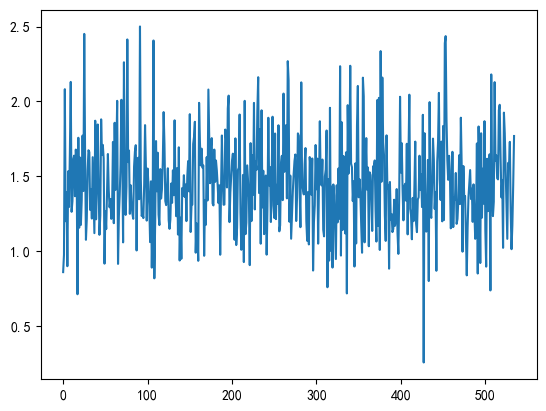

In [17]:
# # 将修改后的权重加载到模型上
# # 当strict=True,要求预训练权重层数的键值与新构建的模型中的权重层数名称完全吻合
# missing_keys, unexpected_keys = model.load_state_dict(pre_weights, strict=False)
# print('miss:', len(missing_keys), 'unexpected:', len(unexpected_keys))
 
# # model.parameters() 代表网络的所有参数
# for params in model.parameters():
#     params.requires_grad = True  # 所有权重参与训练可以更新

# --------------------------------------------- #
#（5）网络编译
# --------------------------------------------- #
# 将模型搬运至GPU上
model.to(device)
# 定义交叉熵损失
loss_function = nn.CrossEntropyLoss()
 
# # 获取所有需要梯度更新的权重参数
# params_optim = []
# # 遍历网络的所有权重
# for p in model.parameters():
#     if p.requires_grad is True:  # 查看权重是否需要更新
#         params_optim.append(p)   # 保存所有需要更新的权重
 
# print('训练参数：', len(params_optim))
 
# 定义优化器，定义学习率，动量，正则化系数
optimizer = optim.SGD(model.parameters(), lr=1e-3,weight_decay=3e-4)
 
 
# --------------------------------------------- #
#（6）训练阶段
# --------------------------------------------- #

losses = []
for epoch in range(5):

    print('='*30)  # 显示当前是第几个epoch
 
    # 将模型设置为训练模式
    model.train()
    # 记录一个epoch的训练集总损失
    total_loss = 0.0
 
    # 每个step训练一个batch，每次取出一个数据集及其标签
    for step, (images, labels) in enumerate(dataloader['train']):
        
        # 将数据集搬运到GPU上
        images, labels = images.to(device), labels.to(device)
        # 梯度清零，因为梯度是累加的
        optimizer.zero_grad()
        # 前向传播==>[b,3]
        logits = model(images)  # 得到每张图属于3个类别的分数
        
        #（1）损失计算
        # 计算每个step的预测值和真实值的交叉熵损失
        loss = loss_function(logits, labels)
        # 累加每个step的损失
        total_loss += loss
        losses.append(loss.item())
        #（2）反向传播
        # 梯度计算
        loss.backward()
        # 梯度更新
        optimizer.step()
        
        # 每50个epoch打印一次损失值
        if step % 20 == 0:
            print(f'step:{step}, train_loss:{loss}')
    # 计算一个epoch的训练集平均损失
    train_loss = total_loss / len(dataloader['train'])
 
# --------------------------------------------- #
#（7）验证训练
# --------------------------------------------- #
    model.eval()  # 切换到验证模式
 
    total_val_loss = 0.0  # 记录一个epoch的验证集总损失
    total_val_correct = 0  # 记录一个epoch中验证集一共预测对了几个
    with torch.no_grad():  # 接下来不计算梯度
        # 每个step验证一个batch
        for (images, labels) in dataloader['val']:
 
            # 将数据集搬运到GPU上
            images, labels = images.to(device), labels.to(device)
            # 前向传播[b,c,h,w]==>[b,3]
            logits = model(images)
 
            #（1）计算损失
            # 计算每个batch的预测值和真实值的交叉熵损失
            loss = loss_function(logits, labels)
            # 累加每个batch的损失，得到一个epoch的总损失
            total_val_loss += loss
 
            #（2）计算准确率
            # 找到预测值对应的最大索引，即该图片对应的类别
            pred = logits.argmax(dim=1)  # [b,3]==>[b]
            # 比较预测值和标签值，计算每个batch有多少预测对了
            val_correct = torch.eq(pred, labels).float().sum()
            # 累加每个batch的正确个数，计算整个epoch的正确个数
            total_val_correct += val_correct

        # 计算一个epoch的验证集的平均损失和平均准确率
        val_loss = total_val_loss / len(dataloader['val'])
        val_acc = total_val_correct / val_num
 
        # 打印每个epoch的训练集平均损失，验证集平均损失和平均准确率
        print('-'*30)
        print(f'train_loss:{train_loss}, val_loss:{val_loss}, val_acc:{val_acc}')
 
# --------------------------------------------- #
#（8）保存权重
# --------------------------------------------- #
        # 保存最小损失值对应的权重文件
        if val_loss < 1.0:   
            # 保存该轮次的权重
            torch.save(model.state_dict(), weightpath)
            # 切换最小损失值
            best_loss = val_loss
            # 打印结果
            print(f'weights has been saved, best_loss has changed to {val_loss}')
plt.plot(losses)

1.5831025838851929